# Dense systems of linear equations

In this notebook, we implement various routines to solve dense linear systems with the LU decomposition. We will start with a naive implementation of the routine that compute the LU decomposition, and we will then try to improve its performance and reduce its memory footprints. Finally, we will implement backward and forward substitution and use these three building blocks to write a function that solves a linear system.

## Packages

As usual, we will deal with `numpy` matrices and vectors, thus we will need to import that package. We will look at some BLAS implementations in `scipy.linalg`, and we will use `timeit` to time our implementations and `matplotlib.pyplot` to plot the results.

In [1]:
import numpy as np

import scipy as sp
from scipy import linalg

import matplotlib
from matplotlib import pyplot as plt

import timeit

## Computing the LU decomposition

Our first task will be to implement efficient algorithms to compute the LU decomposition. In the cell below, you will find working but naive implementation of the so-called "Gaussian elimination" algorithm. This version does not perform row exchanges (also known as pivoting) and uses $O(m^2)$ additional memory.

In [2]:
def is_numpy_matrix(A):
    if type(A) != np.ndarray or A.ndim != 2:
        return False
    else:
        return True

def compute_LU_naive(A):
    """ Compute the LU decomposition using a naive three-loop approach.
        The algorithm requires a quadratic amount of additional memory.
    """
    assert(is_numpy_matrix(A))
    (m, n) = A.shape
    assert(m == n)
    U = A.copy()
    L = np.eye(m)
    for k in range(m-1):
        for i in range(k+1, m):
            L[i, k] = U[i, k] / U[k, k]
            U[i, k] = 0
            for j in range(k+1, m):
                U[i, j] -= L[i, k] * U[k, j]
    return L, U

First of all, let us perform a sanity check by computing the LU decomposition of some small matrices and testing that indeed $LU \approx A$.

In [3]:
def test_LU_decomposition(m, f):
    """ Check that L and U computed by `f`
        satisfy LU = A.
    """
    A = np.random.rand(m, m)
    L, U = f(A)
    if np.allclose(L @ U, A):
        return True
    else:
        return False

def run_sanity_check_LU_decomposition(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        returns two matrices, the L and U factors of the
        LU decomposition of the input.
    """
    for m in range(1, 5):
        assert(test_LU_decomposition(m, f))

f = compute_LU_naive
run_sanity_check_LU_decomposition(f)

The naive implementation features three nested loops, and we should not expect it to be too efficient. As usual, we can improve it by rewriting the loops as higher-level linear algebra operations. You can try to do this by replacing the innermost loop (over `j`) with inner products, or by replacing the two innermost loops (over `i` and `j`) with outer products. As a starting point, you can use the naive implementation above. You should not worry about the addition memory requirement for now.

In [4]:
def compute_LU_inner_products(A):
    """ Compute the LU decomposition using a two-loop approach
        based on inner products. The algorithm requires a
        quadratic amount of additional memory.
    """
    ### BEGIN SOLUTION
    assert(is_numpy_matrix(A))
    (m, n) = A.shape
    assert(m == n)
    U = A.copy()
    L = np.eye(m)
    for k in range(m-1):
        for i in range(k+1, m):
            L[i, k] = U[i, k] / U[k, k]
            U[i, k] = 0
            U[i, k+1:m] -= L[i, k] * U[k, k+1:m]
    return L, U
    ### END SOLUTION
    
    
def compute_LU_outer_products(A):
    """ Compute the LU decomposition using a single-loop approach
        based on outer products. The algorithm requires a
        quadratic amount of additional memory.
    """
    ### BEGIN SOLUTION
    assert(is_numpy_matrix(A))
    (m, n) = A.shape
    assert(m == n)
    U = A.copy()
    L = np.eye(m)
    for k in range(m-1):
        L[k+1:m, k] = U[k+1:m, k] / U[k, k]
        U[k+1:m, k] = 0
        U[k+1:m, k+1:m] -= np.outer(L[k+1:m, k], U[k, k+1:m])
    return L, U
    ### END SOLUTION

We can look for bugs in these implementation using the `run_sanity_check` function defined above.

In [5]:
f = compute_LU_inner_products
run_sanity_check_LU_decomposition(f)
f = compute_LU_outer_products
run_sanity_check_LU_decomposition(f)

Once we are satisfied that our implementations are computing what they are supposed to, we can time them, hoping to see the behaviour we are used to: reducing the number of for loops improves the performance of the code.

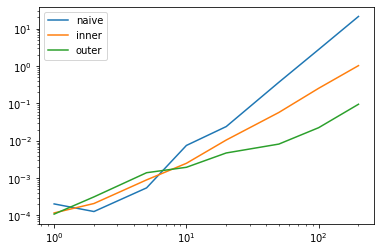

In [6]:
n_reps = 10 # Number of times the timing will be measured.
sizes = np.array([1, 2, 5, 10, 20, 50, 100, 200])
timings = np.zeros([sizes.size, 4])
for i in range(sizes.size):
    m = sizes[i]
    A = np.random.rand(m, m)
    timings[i, 0] = timeit.timeit(lambda: compute_LU_naive(A), number = n_reps)
    timings[i, 1] = timeit.timeit(lambda: compute_LU_inner_products(A), number = n_reps)
    timings[i, 2] = timeit.timeit(lambda: compute_LU_outer_products(A), number = n_reps)
plt.loglog(sizes, timings)
plt.legend(['naive', 'inner', 'outer'])
plt.show()

If our only goal is only to solve the linear system $Ax = b$, then we do not need to keep a copy of $A$ once we have compute $L$ and $U$. In view of this, instead of allocating two separate—and half-empty—additional matrices, we can modify our code to store them in place in $A$, overwriting the original entries of the input matrix. In fact the two matrices only overlap at the main diagonal, but since we know that $L$ is *unit* lower triangular and therefore that $\ell_{ii} = 1$, we do not need to store its diagonal explicitly.

Now try to implement the algorithm that does this computation in place. As a starting point for your implementation, I recommend using the function `compute_LU_outer_products`. The code will be modifying the input matrix `A` rather than creating a new matrix, therefore **your function should not return anything**.

In [7]:
def compute_LU_outer_products_in_place(A):
    ### BEGIN SOLUTION
    if not is_numpy_matrix(A):
        raise Exception("The input must be a numpy matrix.")
    (m, n) = A.shape
    if m != n:
        raise Exception("The input must be a square matrix.")
    for k in range(m):
            A[k+1:m, k] = A[k+1:m, k] / A[k, k]
            A[k+1:m, k+1:m] -= np.outer(A[k+1:m, k], A[k, k+1:m])
    ### END SOLUTION

In [8]:
def test_LU_decomposition_in_place(m, f):
    """ Check that L and U computed by `f`
        satisfy LU = A.
    """
    A = np.random.rand(m, m)
    A_copy = A.copy()
    f(A_copy)
    L = np.tril(A_copy, -1) + np.eye(m)
    U = np.triu(A_copy)
    if np.allclose(L @ U, A):
        return True
    else:
        return False

def run_sanity_check_LU_decomposition_in_place(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        returns two matrices, the L and U factors of the
        LU decomposition of the input.
    """
    for m in range(1, 5):
        assert(test_LU_decomposition_in_place(m, f))

f = compute_LU_outer_products_in_place
run_sanity_check_LU_decomposition_in_place(f)

We can now compare the performance of the two outer product-based implementations. You should see the latter being marginally faster, but the difference should be small for larger matrices. The cell below might take a bit of time to run. As usual, you can reduce `n_reps` to get less accurate measurements faster.

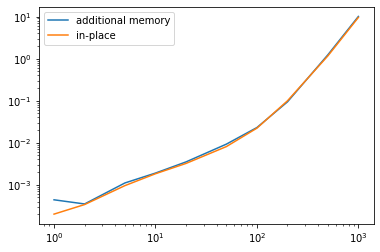

In [9]:
n_reps = 10 # Number of times the timing will be measured.
sizes = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
timings = np.zeros([sizes.size, 4])
for i in range(sizes.size):
    m = sizes[i]
    A = np.random.rand(m, m)
    timings[i, 0] = timeit.timeit(lambda: compute_LU_outer_products(A), number = n_reps)
    timings[i, 1] = timeit.timeit(lambda: compute_LU_outer_products_in_place(A), number = n_reps)
plt.loglog(sizes, timings)
plt.legend(['additional memory', 'in-place'])
plt.show()

## Forward and backward substitution

Now that we have a function to factorise a matrix into the product of two triangular matrices, we need to implement the forward and backward substitution algorithms. These will allow us to solve the two linear systems $Ly = b$ and $Ux = y$. As $L$ is unit lower triangular, we can save $m$ divisions by exploiting the fact that $\ell_{ii} = 1$. You should do that in your implementation. Try to be as efficient as you can, and in particular, try to reduce the number of `for` loops to a minimum.

In [10]:
def is_numpy_vector(x):
    if type(A) != np.ndarray or (A.ndim > 2 and x.shape[1] != 1):
        return False
    else:
        return True

def solve_upper_triangular_system(U, b):
    assert(is_numpy_matrix(U) and is_numpy_vector(b))
    (m, n) = U.shape
    assert(m == n)
    assert(m == b.shape[0])
    ### BEGIN SOLUTION
    x = np.zeros_like(b)
    for i in range(m-1, -1, -1):
        x[i] = b[i]
        x[i] -= U[i, i+1:m] @ x[i+1:m]
        x[i] /= U[i, i]
    return x
    ### END SOLUTION

def solve_unit_lower_triangular_system(L, b):
    assert(is_numpy_matrix(L) and is_numpy_vector(b))
    (m, n) = L.shape
    assert(m == n)
    assert(m == b.shape[0])
    ### BEGIN SOLUTION
    x = np.zeros_like(b)
    for i in range(m):
        x[i] = b[i]
        x[i] -= L[i, 0:i] @ x[0:i]
    return x
    ### END SOLUTION

We will rely on the usual small scale testing in an attempt to smoke out some bugs.

The code below uses the function [`sp.linalg.solve_triangular`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html). This is a very useful function if you want to solve a linear system that you know is triangular, and in these cases it is a better option that [`scipy.linalg.solve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html). The latter is a function you can use to solve any linear system—we will use if below. Both functions rely on lower-level BLAS and LAPACK routines, and are therefore as efficient as it gets. I recommend you check out the documentation to see what their interface looks like and what options they provide.

In [11]:
def test_backward_substitution(m, f):
    """ Compare the result computed by the function `f`
        with computed by `numpy.linalg.solve_triangular` on an
        upper triangular random matrix.
    """
    U = np.triu(np.random.rand(m, m))
    b = np.random.rand(m)
    reference = sp.linalg.solve_triangular(U, b)
    indices = np.tril_indices(m, -1)
    U[indices] = np.nan
    if np.allclose(f(U, b), reference):
        return True
    else:
        return False
    
def run_sanity_check_backward_substitution(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        solves the linear system Ux = b where U is an
        upper triangular matrix.
    """
    for m in range(1, 10):
        assert(test_backward_substitution(m, f))

def test_forward_substitution(m, f):
    """ Compare the result computed by the function `f`
        with computed by `numpy.linalg.solve_triangular` on a
        unit lower triangular random matrix.
    """
    L = np.tril(np.random.rand(m, m), -1)
    b = np.random.rand(m)
    reference = sp.linalg.solve_triangular(L, b, lower=True, unit_diagonal=True)
    indices = np.triu_indices(m, 1)
    L[indices] = np.nan
    if np.allclose(f(L, b), reference):
        return True
    else:
        return False

def run_sanity_check_forward_substitution(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        returns two matrices, the L and U factors of the
        LU decomposition of the input.
    """
    for m in range(1, 10):
        assert(test_forward_substitution(m, f))

f = solve_upper_triangular_system
run_sanity_check_backward_substitution(f)

f = solve_unit_lower_triangular_system
run_sanity_check_forward_substitution(f)

We now have all the ingredients we need to solve a linear system using the LU decomposition without any additional memory requirements. You should implement a function that takes as argument a matrix $A$ and a vector $b$ and then solves the linear $Ax = b$ in four steps.
1. Compute the LU decomposition of $A$ in place.
2. Solve the linear system $Ly = b$ for $y$ without any unnecessary operations.
3. Solve the linear system $Ux = y$ for $x$ without any unnecessary operations.
4. Return $x$.

Try to fill in the function skeleton below. Your implementation should call the functions you implemented above, and if these are correct you should need no more than four lines of code here.

In [12]:
def solve_linear_system_lu(A, b):
    # Validate input.
    if not is_numpy_matrix(A):
        raise Exception("The first argument must be a numpy matrix.")
    (m, n) = A.shape
    if m != n:
        raise Exception("The first argument must be a square matrix.")
    if not is_numpy_vector(b):
        raise Exception("The second argument must be a numpy vector or column matrix.")
    if m != b.shape[0]:
        raise Exception("First and second argument must be conformable.")
    
    ### BEGIN SOLUTION
    compute_LU_outer_products_in_place(A)
    y = solve_unit_lower_triangular_system(A, b)
    x = solve_upper_triangular_system(A, y)
    return x
    ### END SOLUTION

Now we can look for bugs in the implementation with small-scale tests.

In [13]:
def test_LU_solver(m, f):
    """ Compare the result computed by the function `f`
        by the built-in operator `numpy.linalg.solve`.
    """
    A = np.random.rand(m, m)
    b = np.random.rand(m)
    reference = np.linalg.solve(A, b)
    if np.allclose(f(A, b), reference):
        return True
    else:
        return False

def run_sanity_check(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        takes an upper triangular matrix and a vector and
        computes their product.
    """
    for m in range(1, 5):
        assert(test_LU_solver(m, f))

f = solve_linear_system_lu
run_sanity_check(f)